<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/fer2013_Charles_VGG_Continuous_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 224

In [6]:
vgg_notop = VGGFace(model='vgg16', include_top=False, input_shape=(Resize_pixelsize, Resize_pixelsize, 3), pooling='avg')
print(vgg_notop.summary())
last_layer = vgg_notop.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_notop.layers[i].trainable = False

print(vgg_notop.get_layer('pool5').trainable)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])





58916864/58909280 [==============================] - 1s 0us/step






Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
____________________________________________

In [0]:
# Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
def get_data(dataset, bs=32, aug=None, pixelsize=Resize_pixelsize):
    # Data preparation
    while True:
      file_stream = file_io.FileIO(dataset, mode='r')
      datas = pd.read_csv(file_stream,iterator=True, chunksize=bs )
      for data in datas:
          data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
          X, Y = data[' pixels'].tolist(), data['emotion'].values
          X = np.array(X, dtype='float32').reshape(-1,48,48,1)
          X = X/255.0
          X_res = np.zeros((X.shape[0], pixelsize,pixelsize,3))
          for ind in range(X.shape[0]): 
              sample = X[ind]
              sample = sample.reshape(48, 48)
              image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
              X_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)

          Y_res = np.zeros((Y.size, 7))
          Y_res[np.arange(Y.size),Y] = 1
          if aug is not None:
              (X_res, Y_res) = next(aug.flow(np.array(X_res),
                  Y_res, batch_size=bs))
          yield  X_res, Y_res

In [0]:
training_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/train.csv'
dev_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv'
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'

aug = ImageDataGenerator(
    rotation_range  = 10,
#    shear_range     = 10, # 10 degrees
    zoom_range      = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True
)


train_generator = get_data(training_dataset_dir,  bs=BS, aug=aug)
dev_generator   = get_data(dev_dataset_dir, bs=BS, aug=None)
test_generator   = get_data(test_dataset_dir, bs=BS, aug=None)
    #X_dev_res, Y_dev_res  = get_data(dev_dataset_dir)

# Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches) indefinitely
# rescale:          Rescaling factor (defaults to None). Multiply the data by the value provided (before applying any other transformation)
# rotation_range:   Int. Degree range for random rotations
# shear_range:      Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
# zoom_range:       Float or [lower, upper]. Range for random zoom. If a float, [lower, upper] = [1-zoom_range, 1+zoom_range]
# fill_mode :       Points outside the boundaries of the input are filled according to the given mode: {"constant", "nearest", "reflect" or "wrap"}
# horizontal_flip:  Boolean. Randomly flip inputs horizontally


# Takes numpy data & label arrays, and generates batches of augmented/normalized data. Yields batcfillhes indefinitely, in an infinite loop
    # x:            Data. Should have rank 4. In case of grayscale data, the channels axis should have value 1, and in case of RGB data, 
    #               it should have value 3
    # y:            Labels
    # batch_size:   Int (default: 32)
#train_generator = train_datagen.flow(X_train_res, Y_train_res,  batch_size  = BS)

In [0]:
from sklearn.utils import class_weight
file_stream = file_io.FileIO('/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv', mode='r')
data = pd.read_csv(file_stream)

#data = pd.read_csv('fer2013/fer2013.csv')
data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

# Retrieve train input and target
X, Y = data[' pixels'].tolist(), data['emotion'].values


class_weights = class_weight.compute_class_weight('balanced',
                                                    np.unique(Y),
                                                    Y)


In [10]:
history = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    steps_per_epoch=28709// BS,
    validation_steps=3509 // BS,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[rlrop],
    use_multiprocessing=True,
    class_weight=class_weights
) 

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
224/224 [==============================] - 439s 2s/step - loss: 1.4365 - acc: 0.4560 - val_loss: 1.1685 - val_acc: 0.5735
Epoch 2/50
224/224 [==============================] - 426s 2s/step - loss: 1.1952 - acc: 0.5560 - val_loss: 1.1114 - val_acc: 0.5926
Epoch 3/50
224/224 [==============================] - 425s 2s/step - loss: 1.1434 - acc: 0.5751 - val_loss: 1.0920 - val_acc: 0.5965
Epoch 4/50
224/224 [==============================] - 426s 2s/step - loss: 1.1182 - acc: 0.5804 - val_loss: 1.0652 - val_acc: 0.6070
Epoch 5/50
224/224 [==============================] - 421s 2s/step - loss: 1.0936 - acc: 0.5937 - val_loss: 1.0395 - val_acc: 0.6043
Epoch 6/50
224/224 [==============================] - 420s 2s/step - loss: 1.0767 - acc: 0.5965 - val_loss: 1.0286 - val_acc: 0.6151
Epoch 7/50
224/224 [==============================] - 422s 2s/step - loss: 1.0588 - acc: 0.6059 - val_loss

In [11]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
dev loss, dev acc: [0.9015585691840561, 0.6820023148148148]


In [12]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [0.8534441546157554, 0.6947337962962963]


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


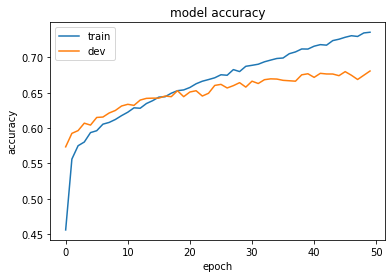

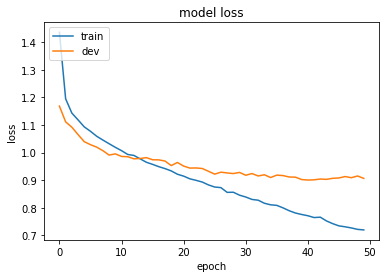

In [14]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [0]:
lr_str = '-SGD_LR_%.5f' % SGD_LEARNING_RATE
epoch_str = '-EPOCHS_' + str(EPOCHS)
bs_str = '-BS_' + str(BS)
dropout_str = '-DROPOUT_' + str(DROPOUT_RATE)
test_acc = '-test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/cs230 project/models/tl/vgg16-19-tl' + lr_str + epoch_str + bs_str + dropout_str + test_acc + '.h5')

In [0]:
def get_data_for_test(dataset, pixelsize = Resize_pixelsize):
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

    X, Y = data[' pixels'].tolist(), data['emotion'].values
    X = np.array(X, dtype='float32').reshape(-1,48,48,1)
    X = X/255.0
    X_res = np.zeros((X.shape[0], pixelsize,pixelsize,3))
    for ind in range(X.shape[0]):  #X_dev.shape[0]
        sample = X[ind]
        sample = sample.reshape(48, 48)
        image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
        X_res[ind,:,:,:] = image_resized.reshape(pixelsize,pixelsize,1)

    Y_res = np.zeros((Y.size, Y.max()+1))
    Y_res[np.arange(Y.size),Y] = 1
    
    return  X_res, Y_res

In [0]:
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'
X_test_res, Y_test_res  = get_data_for_test(test_dataset_dir)

In [18]:
model.evaluate(X_test_res, Y_test_res)


3589/3589 [==============================] - 11s 3ms/step


[0.8526672750885821, 0.6943438283810545]

In [19]:
from sklearn.metrics import accuracy_score

# configure image data augmentation
tta_aug = ImageDataGenerator(
    # rotation_range  = 10,
    # shear_range     = 10, # 10 degrees
    # zoom_range      = 0.1,
    # fill_mode       = 'reflect',
    horizontal_flip = True
)

# make a prediction using test-time augmentation
def tta_prediction(model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
  test_generator = get_data(test_dataset_dir, bs=BS, aug=tta_aug)
	it = test_generator.flow(samples, batch_size=n_examples)
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

IndentationError: ignored

In [0]:
print('\n# Evaluate on test data')
TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)